In [1]:
import os, shutil, time, copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from MusicData import MusicData

# input parameters
x_len = 80
y_len = 40
batch_size = 32
n_samples = 4096
# LSTM parameters
num_layers = 2
lstm_size = 50
dropout_prob = 0.2
# training parameters
num_epochs = 100
epoch_size = 4096
verbose = True
display_interval = 500
moving_avg_length = 100
learn_rate = 0.001
momentum = 0.8
step_size = 50
gamma = 0.5

# fix random seed for reproducibility
np.random.seed(7)

## Load data

Sample rate: 44100


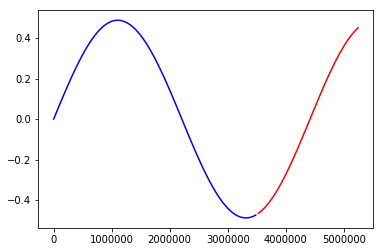

In [2]:
# filelist = ['a2002011001-e02.wav']
filelist = ['sine.wav']
music_data = MusicData(filelist, x_len, y_len)
x_ex, y_ex = music_data.data[0]['x'], music_data.data[0]['y']

print('Sample rate: {}'.format(music_data.sample_rate))
x_duration = music_data.sample_rate * len(x_ex)
x = np.linspace(0, x_duration, len(x_ex), endpoint=False)
y_duration = music_data.sample_rate * len(y_ex) + x_duration
y = np.linspace(x_duration, y_duration, len(y_ex), endpoint=False)

plt.plot(x, x_ex, 'b')
plt.plot(y, y_ex, 'r')
plt.show()

## Make DataLoader

In [3]:
phases = ['train']
dataset = {'train': music_data}
from torch.utils.data.sampler import RandomSampler, BatchSampler
samplers = {x: BatchSampler(sampler=RandomSampler(dataset[x]), batch_size=batch_size, drop_last=True)
            for x in phases}
dataloader = {x: DataLoader(dataset[x], num_workers=4, batch_sampler=samplers[x])
              for x in phases}
dataset_sizes = {'train': len(music_data.data)}

## Build model

In [4]:
class MusicRNN(nn.Module):
    def __init__(self, x_len, y_len, num_layers=1, hidden_nodes=50, dropout=0.0, batch_size=batch_size):
        super().__init__()
        self.x_len = x_len
        self.y_len = y_len
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.dropout = dropout
                
        # define net parameters
        self.rnn = nn.LSTM(x_len, hidden_nodes, num_layers=num_layers, dropout=dropout)
        self.n_hidden_nodes = hidden_nodes
        self.ln1 = nn.Linear(hidden_nodes, y_len)
        
    def init_hidden(self, hidden_nodes):
        return (torch.zeros(self.num_layers, self.batch_size, hidden_nodes),
                torch.zeros(self.num_layers, self.batch_size, hidden_nodes))
        
    def forward(self, x): 
        self.hidden = self.init_hidden(self.n_hidden_nodes)
        x, self.hidden = self.rnn(x, self.hidden)
        x = self.ln1(x)
        return x


In [5]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

rnn_model = MusicRNN(x_len, y_len, num_layers=num_layers, hidden_nodes=lstm_size, dropout=dropout_prob, 
                     batch_size=batch_size)

rnn_model = rnn_model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.RMSprop(rnn_model.parameters(), lr=learn_rate, momentum=momentum)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Define training

In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, 
                phases, dataset_sizes, device=None, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    retain = True
    for epoch in range(num_epochs):
        # display epoch
        print('Epoch {} / {}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            # reset loss for current phase and epoch
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = torch.unsqueeze(inputs, 0).to(device)
                labels = torch.unsqueeze(labels, 0).to(device)
                
                optimizer.zero_grad()
                
                # track history only during training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(1)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:.4f}'.format(best_acc))
    
#     model.load_state_dict(best_model_wts)
    return model

## Train

In [7]:
rnn_model = train_model(rnn_model, dataloader, criterion, optimizer, scheduler, 
                        phases, dataset_sizes, device=device, num_epochs=num_epochs)

Epoch 0 / 99
----------
train Loss: 0.0319

Epoch 1 / 99
----------
train Loss: 0.0023

Epoch 2 / 99
----------
train Loss: 0.0017

Epoch 3 / 99
----------
train Loss: 0.0014

Epoch 4 / 99
----------
train Loss: 0.0012

Epoch 5 / 99
----------
train Loss: 0.0011

Epoch 6 / 99
----------
train Loss: 0.0010

Epoch 7 / 99
----------
train Loss: 0.0009

Epoch 8 / 99
----------
train Loss: 0.0008

Epoch 9 / 99
----------
train Loss: 0.0009

Epoch 10 / 99
----------
train Loss: 0.0008

Epoch 11 / 99
----------
train Loss: 0.0008

Epoch 12 / 99
----------
train Loss: 0.0008

Epoch 13 / 99
----------
train Loss: 0.0008

Epoch 14 / 99
----------
train Loss: 0.0006

Epoch 15 / 99
----------
train Loss: 0.0007

Epoch 16 / 99
----------
train Loss: 0.0007

Epoch 17 / 99
----------
train Loss: 0.0006

Epoch 18 / 99
----------
train Loss: 0.0006

Epoch 19 / 99
----------
train Loss: 0.0005

Epoch 20 / 99
----------
train Loss: 0.0005

Epoch 21 / 99
----------
train Loss: 0.0007

Epoch 22 / 99
------

## More complex RNN model

In [ ]:
class MusicRNN(nn.Module):
    def __init__(self, x_len, y_len, num_layers=1, hidden_nodes=[50], dropout=0.0):
        super().__init__()
        self.x_len = x_len
        self.y_len = y_len
        self.num_layers = num_layers
        self.hidden_nodes = {}
        for i, h_n in enumerate(hidden_nodes):
            self.hidden_nodes['rnn{}'.format(i)] = self.init_hidden(h_n)
        self.dropout = dropout
                
        # define net parameters
        self.net = {}
        for i, hl in enumerate(hidden_nodes):
            if i == 0:
                layer_in = x_len
                
            self.net['rnn{}'.format(i + 1)] = nn.LSTM(layer_in, hl, num_layers=1, dropout=dropout)
            layer_in = hl
            
        self.ln1 = nn.Linear()
        
    def init_hidden(self, hidden_nodes):
        return (torch.zeros(1, 1, hidden_nodes),
                torch.zeros(1, 1, hidden_nodes))
        
    def forward(self, x):
        for i in range(self.num_layers):
            x, self.hidden = self.net['rnn{}'.format(i + 1)](x, self.hidden)
        pass